### Ablation Study 

This code is a part of the experiments conducted in the Ablation study section.  A model is trained using the CIFAR100 dataset and is loaded here and tested using GRAD CAM++. 

In [63]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
import numpy as np
import pickle
import keras 
from keras.layers.core import Lambda
from keras import backend as K
from keras.models import Model
tf.compat.v1.disable_eager_execution()

from skimage import io
from skimage.transform import resize
from scipy.misc import imread, imresize
from matplotlib import pyplot as plt
import cv2

In [64]:
#!pip install scipy==1.1.0


In [65]:
InputModel = keras.models.load_model('CIFAR100_model' )

In [66]:
InputModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 activation (Activation)     (None, 32, 32, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        2336      
                                                                 
 activation_1 (Activation)   (None, 16, 16, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                    

/tmp/ipykernel_58393/2266235118.py:3: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.
  img = imread(ImgPath, mode='RGB')
/tmp/ipykernel_58393/2266235118.py:4: DeprecationWarning:     `imresize` is deprecated!
    `imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``skimage.transform.resize`` instead.
  img = imresize(img, (32, 32))


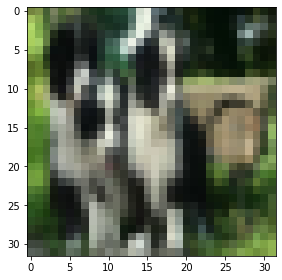

In [67]:
ImgPath = 'collies.JPG'

img = imread(ImgPath, mode='RGB')
img = imresize(img, (32, 32))
io.imshow(img)
plt.show()

x = np.expand_dims(img, axis=0) # [224,224 , 3 ] -> [1 , 224,224 , 3 ]
x = x[:,:,:,::-1]

prob = InputModel.predict(x) ## Generate the Predictions Vector 

input_img =  x


In [68]:
predicted_class = np.argmax(prob) ## Get the predicted Class i.e. the class with the maximum prediction accuracy 


layer_name = 'activation_4' 

NumClasses = np.shape(prob)[1]


In [69]:
def target_category_loss(x, category_index, nb_classes):
    return tf.multiply(x, K.one_hot([category_index], nb_classes))

In [70]:
def target_category_loss_output_shape(input_shape):
    return input_shape

In [71]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)

In [72]:
target_layer = lambda x: target_category_loss(x, predicted_class, NumClasses)
x = Lambda(target_layer, output_shape = target_category_loss_output_shape)(InputModel.output)

model = Model(inputs=InputModel.input, outputs=x)

In [73]:
loss = K.sum(model.output)

for l in model.layers:
    
    if( l.name == layer_name ):
        conv_output = l.output

In [74]:
## Determine gradeints  The below code implements 
#Eq. 19 in the GRAD CAM++ paper (https://arxiv.org/pdf/1710.11063.pdf)

grads = normalize(K.gradients(loss, conv_output)[0])
gradient_function = K.function([model.layers[0].input], [conv_output, grads])
activation_maps, grads_val = gradient_function([input_img])
activation_maps = activation_maps[ 0 , :]
grads_val = grads_val[0 , :]

grads2 =  grads_val*grads_val
grads3  = grads_val*grads_val*grads_val



alpha_numerator = grads2
alpha_demonimator1 = 2*grads2


scale = np.sum( activation_maps , axis=( 0 , 1) )

alpha_demonimator2  = scale*grads3
alpha_demonimator2 = np.where(alpha_demonimator2 != 0.0, alpha_demonimator2, np.ones(alpha_demonimator2.shape))

alpha_demonimator =  alpha_demonimator2 + alpha_demonimator1
alpha = alpha_numerator/alpha_demonimator

weights1 = np.maximum(grads_val , 0 )

alphas_threshold_relu = np.where(weights1, alpha, 0.0)
alpha_normalized = np.sum(np.sum(alphas_threshold_relu, axis=0),axis=0)

alpha_normalized = np.where(alpha_normalized != 0.0, alpha_normalized, np.ones(alpha_normalized.shape))
alpha /= alpha_normalized.reshape((1,1,activation_maps.shape[2]))

deep_linearization_weights = np.sum((weights1*alpha).reshape((-1,activation_maps.shape[2])),axis=0)

dim = np.shape(activation_maps)[0]
localization_result = np.ones( (dim, dim) , dtype =np.float32 )

for i in range( len(deep_linearization_weights)):
    localization_result += deep_linearization_weights[i]*activation_maps[: , : , i]






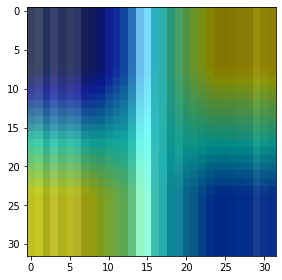

In [75]:
cam = cv2.resize(localization_result, (32, 32))
cam = np.maximum(cam, 0)
heatmap = cam / np.max(cam)

    #Return to BGR [0..255] from the preprocessed image
image = img[0, :]
image -= np.min(image)
image = np.minimum(image, 255)
cam = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
cam = np.float32(cam) + np.float32(image)
cam = 255 * cam / np.max(cam)
cam = np.uint8(cam)

io.imshow(cam)
plt.show()
cam = cv2.resize( cam , (224, 224))


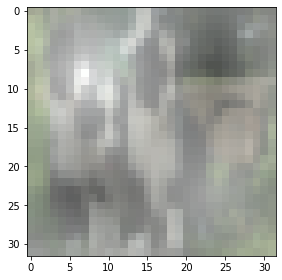

In [76]:
localization_result = np.maximum (localization_result , 0 )
localization_result = localization_result / np.max(localization_result)
localization_result = resize(localization_result, (32,32))
cam3 = np.expand_dims(localization_result, axis=2)
cam3 = np.tile(cam3,[1,1,3])
img = img.astype(float)
img /= img.max()
new_img = img+3*cam3
new_img /= new_img.max()

io.imshow(new_img)
plt.show()

new_img = cv2.resize( new_img , (224, 224))
